In [1]:
!pip install git+https://github.com/sebastian-sz/efficientnet-v2-keras@main

  Cloning https://github.com/sebastian-sz/efficientnet-v2-keras (to revision main) to /tmp/pip-req-build-6q9qot0_
  Created wheel for efficientnet-v2-keras: filename=efficientnet_v2_keras-1.0-py3-none-any.whl size=15400 sha256=32ea7b9957ba5ecafb9c6b1524d5e8dba15f50ebeaf8e7a7a53ffd2404c45ab0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ua7o1e1n/wheels/9f/64/18/5e19e68f416c0dd72251d3f4700f7df9da70d3e8ccfa2bf844
Successfully built efficientnet-v2-keras
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from efficientnet_v2 import EfficientNetV2M

%matplotlib inline

In [ ]:
# import shutil
# for i in ['train', 'valid', 'test']:
#     shutil.rmtree('./data/{}/.ipynb_checkpoints'.format(i))

In [2]:
sorted(os.listdir('./data/train'))

['10_sushi_mura',
 '11_ugo',
 '1_nakseong',
 '2_scuba',
 '3_osteria',
 '4_hou_skewer',
 '5_gravy',
 '6_jungga',
 '7_edong_gan',
 '8_hwanyeo',
 '9_badarang']

In [3]:
class_num = 11
batch_size=32
target_size=(200,200)

gen = ImageDataGenerator(rescale=1/255.)
train_gen = gen.flow_from_directory('./data/train/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = gen.flow_from_directory('./data/valid/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = gen.flow_from_directory('./data/test/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

Found 27115 images belonging to 11 classes.
Found 8977 images belonging to 11 classes.
Found 8976 images belonging to 11 classes.


In [4]:
from tensorflow.keras.applications import Xception

Xception_base = Xception(weights='imagenet',
                 include_top=False,        # class 3개로 분류 학습시켜야 해서 레이어 분리시킨 후, Desnse(3) 추가..?
                 input_shape=(200, 200, 3))

Xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
model_Xception = models.Sequential()
model_Xception.add(Xception_base)
model_Xception.add(layers.Flatten())
model_Xception.add(layers.Dense(256, activation='relu'))
model_Xception.add(layers.Dense(11, activation='sigmoid'))
Xception_base.trainable = False
model_Xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2827      
Total params: 46,554,675
Trainable params: 25,693,195
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#저장할 모델명(폴더명)
model_name = 'Xception'

#폴더생성
if 'save_models' not in os.listdir(): os.mkdir('save_models')
if model_name not in os.listdir('save_models'): os.mkdir('./save_models/{}'.format(model_name))
#모델 저장 path
path_checkpoint = "./save_models/{}/".format(model_name) 
#모델 저장 코드(weight만 저장)
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, save_weights_only=False, save_best_only=True, save_format='tf')

#fit
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_Xception.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
history = model_Xception.fit(train_gen, validation_data=valid_gen, batch_size=batch_size, epochs=10, callbacks=[es_callback, modelckpt_callback])

Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.5387
Epoch 00001: val_loss improved from inf to 0.87983, saving model to ./save_models/Xception/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save_models/Xception/assets
848/848 [==============================] - 94s 110ms/step - loss: 0.8077 - accuracy: 0.5387 - val_loss: 0.8798 - val_accuracy: 0.8576
Epoch 2/10
 36/848 [>.............................] - ETA: 50s - loss: 0.0950 - accuracy: 0.9722

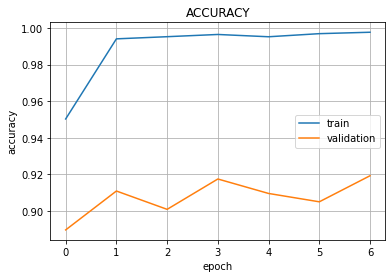

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['train','validation'], loc = 'best')

In [ ]:
#저장된 최고 성능 모델 불러오기
model_loaded = tf.keras.models.load_model(path_checkpoint)

#test score 확인
score = model_loaded.evaluate(test_gen) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

In [10]:
# 폴더 제거
import shutil
for i in ['Xception']: shutil.rmtree(i)